In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.fftpack as sf
import scipy.constants as sc

点目标仿真

In [2]:
R_ref = 1000e+3
Vr = 7100
Tr = 40e-6
Kr = 0.5e+12
f0 = 5.3e+09

Fr = 24e+6 
Fa = 1700
delta_fdop = 1338
theta_sqc = 8*np.pi/180

Ta = 0.64

La = 10

In [3]:
Vs = Vr*1.06
Vg = Vr*0.94
theta_rc = np.arcsin(np.sin(theta_sqc)*Vr/Vg)
f_etac = 2*Vs*np.sin(theta_sqc)*f0/sc.c
theta_bw = 0.886*sc.c/f0/La
Naz = Ta*Fa
Nrg = Tr*Fr


R_0 = R_ref + 20e+3             #零多普勒面斜距
R_etac = R_0/np.cos(theta_rc)
eta_c = -R_0*np.tan(theta_rc)/Vr
N_az = int(2*Naz)
N_rg = int(2*Nrg)

eta = np.linspace(-Ta, Ta - 1/Fa, N_az)
tau = np.linspace(-Tr, Tr - 1/Fr, N_rg) 
eta = eta.reshape(N_az,1)
tau = tau.reshape(1,N_rg)

eta_array = eta + eta_c

print('R_etac:',R_etac,'eta_c:',eta_c)
print(N_az,N_rg,f_etac,theta_rc*180/np.pi)

R_etac: 1031366.7907969796 eta_c: -21.507119344088505
2176 1920 37034.34605065948 8.514314090791315


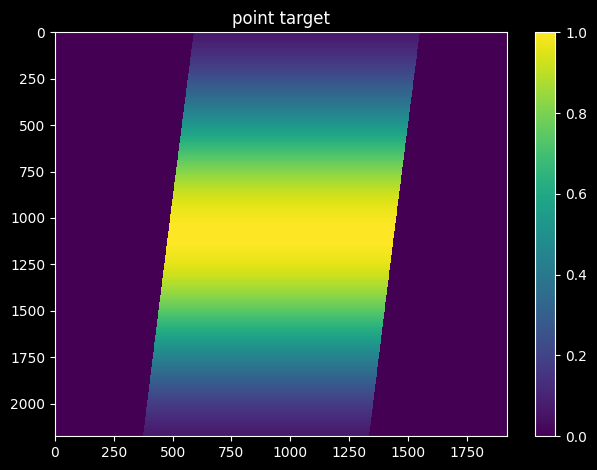

In [4]:
R_eta = np.sqrt(R_0**2 + (Vr*(eta_array))**2)  
rectan_rg = (np.abs(tau-2*(R_eta-R_etac)/sc.c)<=Tr/2)

S_2d= rectan_rg*np.sinc(0.886*np.arctan(Vr*(eta_array-eta_c)/R_0)/theta_bw)**2*np.exp(-1j*4*np.pi*R_eta*f0/sc.c)\
          *np.exp(1j*np.pi*Kr*(tau-2*(R_eta-R_etac)/sc.c)**2)       #center :(eta_c, R_etac)

# S_2d = S_2d*np.exp(-1j*2*np.pi*f_etac*eta_array)      #将多普勒频偏置于0频处
plt.figure()
plt.pcolormesh(np.abs(S_2d))
bottom,top = plt.ylim()
plt.ylim(top,bottom)
plt.title('point target')
plt.colorbar()
plt.tight_layout()
plt.show()

距离多普勒域

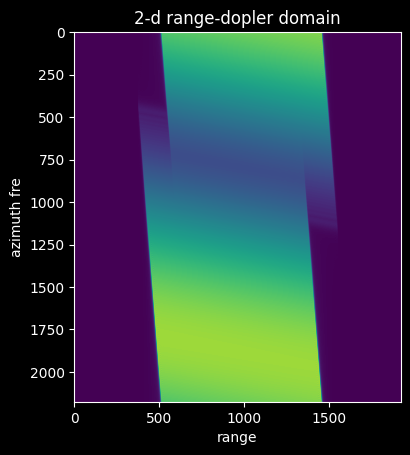

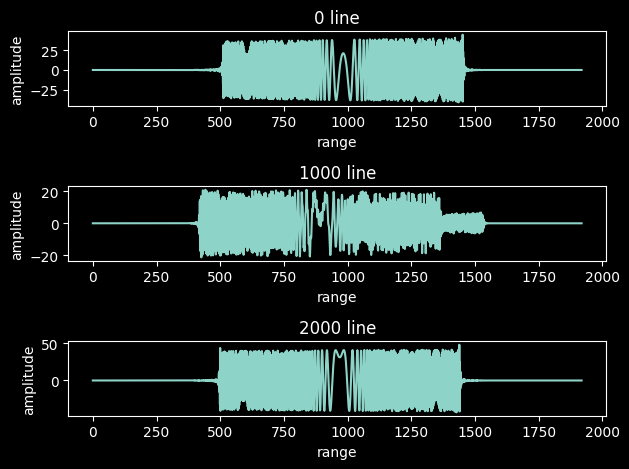

In [5]:
N_azimuth_fft = N_az
N_range_fft = N_rg
S_rdf = sf.fft(S_2d,axis=0)
plt.figure()
plt.imshow((np.abs(S_rdf)))
plt.title('2-d range-dopler domain')
plt.xlabel('range')
plt.ylabel('azimuth fre')
plt.show()

plt.figure()
# plt.colorbar()
plt.subplot(3,1,1)
plt.plot(range(N_rg),(np.real(S_rdf[0,:])))
plt.title('0 line')
plt.xlabel('range')
plt.ylabel('amplitude')

plt.subplot(3,1,2)
plt.plot(range(N_rg),(np.real(S_rdf[1000,:])))
plt.title('1000 line')
plt.xlabel('range')
plt.ylabel('amplitude')

plt.subplot(3,1,3)
plt.plot(range(N_rg),(np.real(S_rdf[2000,:])))
plt.title('2000 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.tight_layout()
plt.show()

距离徙动示意

[1020001.5450152]


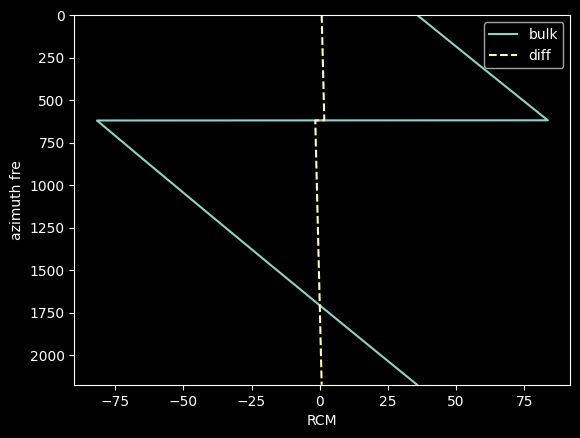

In [6]:
f_rg = np.fft.fftshift(np.linspace(-Fr/2, Fr/2 - Fr/N_range_fft, N_range_fft))
f_rg -= np.round((f_rg - 0) / Fr) * Fr
f_azi = np.fft.fftshift(np.linspace(-Fa/2, Fa/2 - Fa/N_azimuth_fft, N_azimuth_fft))
f_azi = f_azi + np.round((-f_azi+f_etac)/Fa)*Fa

f_azi_ref = f_etac

tau_fft = np.linspace(-Tr, Tr - Tr/N_range_fft, N_range_fft) 
tau_array = tau_fft + 2*R_etac/sc.c
R0_tau = tau_array*sc.c/2* np.cos(theta_rc)    #距离向的最小斜距
R0_tau = R0_tau.reshape(1, N_range_fft)
print(R0_tau[:,int(N_rg/2)])

D_fV = np.sqrt(1-sc.c**2*f_azi**2/4/Vr**2/f0**2).reshape(N_azimuth_fft,1)
D_fV_ref = np.sqrt(1-sc.c**2*f_azi_ref**2/4/Vr**2/f0**2)

range_pixel = sc.c/Fr/2
# D_rcm = np.sqrt(1-(sc.c/f0)**2*f_azi.reshape(len(f_azi),1)**2/(4*Vr**2))
# D_rcm_ref = np.sqrt(1-(sc.c/f0)**2*f_azi_ref**2/(4*Vr**2))
# RCM_Q = (R_0 - R_etac + R0_tau/D_rcm - R0_tau)/range_pixel
# RCM_Q_Ref = (R_0 - R_etac + R_ref/D_rcm_ref - R_ref)/range_pixel

RCM_total = R0_tau*(1/D_fV - 1/D_fV_ref)/range_pixel   #RCM_Q - RCM_Q_Ref
RCM_bulk = R_ref*(1/D_fV - 1/D_fV_ref)/range_pixel 
RCM_diff = RCM_total - RCM_bulk


plt.figure()
plt.plot(RCM_bulk,range(N_azimuth_fft),label = 'bulk')
plt.plot(RCM_diff[:,int(N_rg/2)],range(N_azimuth_fft),'--',label = 'diff')
plt.legend()
plt.ylabel('azimuth fre')
plt.xlabel('RCM')
plt.ylim(N_azimuth_fft-1,0)
plt.show()

一致距离校正 + 距离压缩

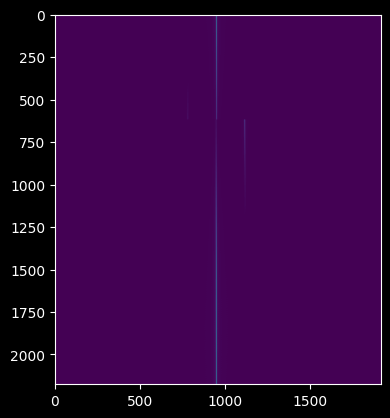

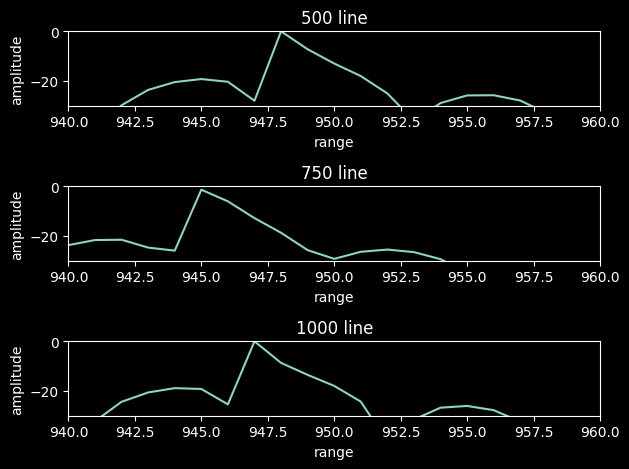

In [7]:
S_2df = sf.fft(S_rdf,axis=1)
f_azi = f_azi.reshape(N_azimuth_fft,1)
f_rg = f_rg.reshape(1,N_range_fft)
K_m = Kr/(1-Kr*sc.c*R_ref*f_azi**2/(2*Vr**2*f0**3*D_fV**3))    #参考距离下的Km
window = ss.get_window(window=('kaiser',0),Nx=N_rg)  # 时域窗
Window = np.fft.fftshift(window)  # 频域窗
H_m3 = np.exp(1j*np.pi*D_fV/K_m/D_fV_ref*f_rg**2)*np.exp(1j*4*np.pi*(1/D_fV - 1/D_fV_ref)*R_ref*f_rg/sc.c)*window
S_rdf_1 = sf.ifft(S_2df*H_m3,axis=1)

plt.figure()
plt.imshow(np.abs(S_rdf_1))
plt.show()

plt.figure()
# plt.colorbar()
plt.subplot(3,1,1)
plt.plot(range(N_rg),20*np.log10(np.abs(S_rdf_1[500,:])/np.max(np.abs(S_rdf_1[500,:]))))
plt.title('500 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.xlim(940,960)
plt.ylim(-30,0)

plt.subplot(3,1,2)
plt.plot(range(N_rg),20*np.log10(np.abs(S_rdf_1[750,:])/np.max(np.abs(S_rdf_1[750,:]))))
plt.title('750 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.xlim(940,960)
plt.ylim(-30,0)

plt.subplot(3,1,3)
plt.plot(range(N_rg),20*np.log10(np.abs(S_rdf_1[2000,:])/np.max(np.abs(S_rdf_1[2000,:]))))
plt.title('1000 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.xlim(940,960)
plt.ylim(-30,0)

plt.tight_layout()
plt.show()

Chirp Scaling + 距离压缩

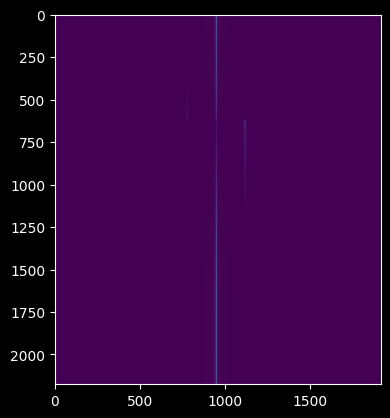

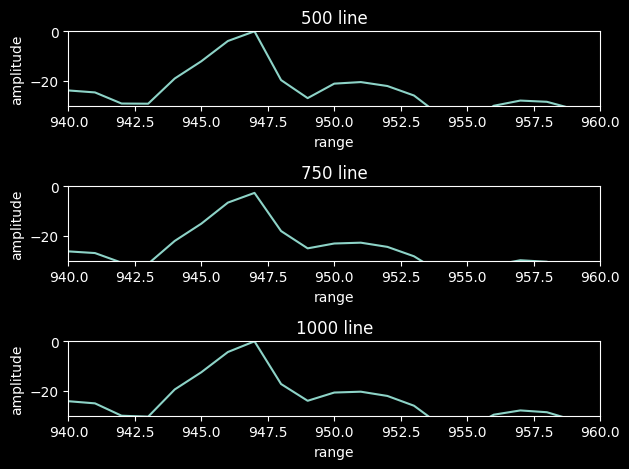

In [8]:
R_etac_ref = R_ref/np.cos(theta_rc)
scaling_func = np.exp(1j*np.pi*K_m*(D_fV_ref/D_fV -1)*(tau_array-2*R_etac_ref/sc.c)**2)
S_rdf_2 = S_rdf*scaling_func
S_2df_2 = sf.fft(S_rdf_2,axis=1)
S_rdf_2 = sf.ifft(S_2df_2*H_m3,axis=1)

plt.figure()
plt.imshow(np.abs(S_rdf_2))
plt.show()

plt.figure()
# plt.colorbar()
plt.subplot(3,1,1)
plt.plot(range(N_rg),20*np.log10(np.abs(S_rdf_2[500,:])/np.max(np.abs(S_rdf_2[500,:]))))
plt.title('500 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.xlim(940,960)
plt.ylim(-30,0)

plt.subplot(3,1,2)
plt.plot(range(N_rg),20*np.log10(np.abs(S_rdf_2[750,:])/np.max(np.abs(S_rdf_2[750,:]))))
plt.title('750 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.xlim(940,960)
plt.ylim(-30,0)

plt.subplot(3,1,3)
plt.plot(range(N_rg),20*np.log10(np.abs(S_rdf_2[1000,:])/np.max(np.abs(S_rdf_2[1000,:]))))
plt.title('1000 line')
plt.xlabel('range')
plt.ylabel('amplitude')
plt.xlim(940,960)
plt.ylim(-30,0)

plt.tight_layout()
plt.show()

#结果不完全好，原因可能有Km距离固定，不是完全的线性关系，速度也不是完全固定

方位处理

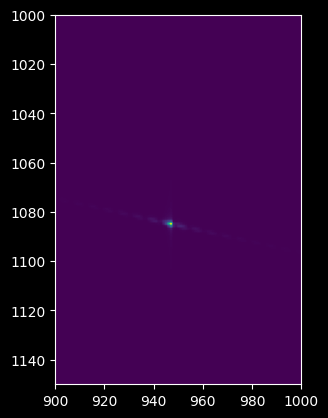

In [9]:
H_m4 = np.exp(1j*4*np.pi*R0_tau*f0*D_fV/sc.c)*np.exp(-1j*4*np.pi*K_m/sc.c**2*(1-D_fV/D_fV_ref)*((R0_tau/D_fV - R_ref/D_fV))**2)
# F(f)*H_offset -> f(t-eta_c)  与最开始定义原数据对齐
Haf_offset = np.exp(-1j*2*np.pi*(f_azi.reshape(len(f_azi),1))*eta_c)
S_m = sf.ifft(S_rdf_2*H_m4*Haf_offset,axis=0)
H_restore = np.exp(1j*4*np.pi*R_0/(sc.c/f0))
S_m = S_m*H_restore
plt.figure()
plt.imshow(np.abs(S_m))
plt.ylim(1150,1000)
plt.xlim(900,1000)
plt.show()

点目标升采样

1085 47


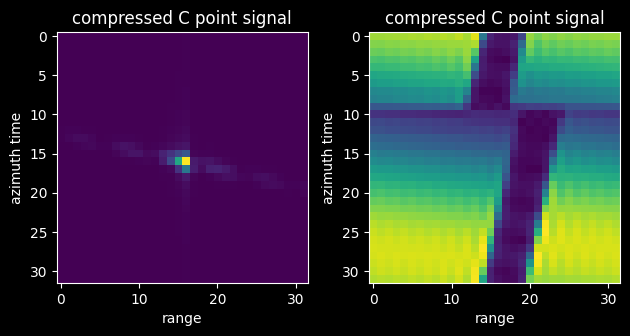

In [10]:
                                                             
C_compoint_range = S_m[:,900:1000]

com_center_y,com_center_x = np.abs(C_compoint_range).argmax()//C_compoint_range.shape[1],\
                            np.remainder(np.abs(C_compoint_range).argmax(),C_compoint_range.shape[1])

print(com_center_y,com_center_x)

C_point = C_compoint_range[com_center_y-16:com_center_y+16,com_center_x-16:com_center_x+16]
# C_point = S_mf_2[:,com_center_x-16:com_center_x+16]
plt.figure()
plt.subplot(1,2,1)
plt.imshow((np.abs(C_point)))
plt.title('compressed C point signal')
plt.xlabel('range')
plt.ylabel('azimuth time')

plt.subplot(1,2,2)
plt.imshow(np.abs((sf.fft2((C_point)))))
plt.title('compressed C point signal')
plt.xlabel('range')
plt.ylabel('azimuth time')

plt.tight_layout()
plt.show()

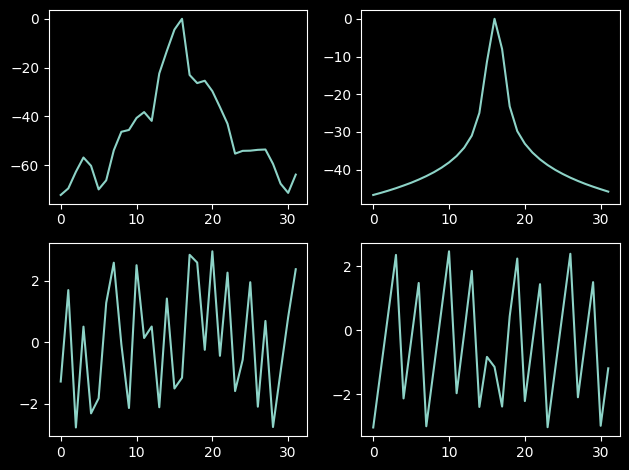

In [11]:
center_y,center_x = np.abs(C_point).argmax()//C_point.shape[1],\
                            np.remainder(np.abs(C_point).argmax(),C_point.shape[1])

plt.figure()
plt.subplot(2,2,1)
plt.plot(range(C_point.shape[1]),20*np.log10(np.abs(C_point[center_y,:])/np.max(np.abs(C_point[center_y,:]))))

plt.subplot(2,2,2)
plt.plot(range(C_point.shape[0]),20*np.log10(np.abs(C_point[:,center_x])/np.max(np.abs(C_point[:,center_x]))))

plt.subplot(2,2,3)
plt.plot(range(C_point.shape[1]),(np.angle(C_point[center_y,:])))

plt.subplot(2,2,4)
plt.plot(range(C_point.shape[0]),(np.angle(C_point[:,center_x])))

plt.tight_layout()
plt.show()

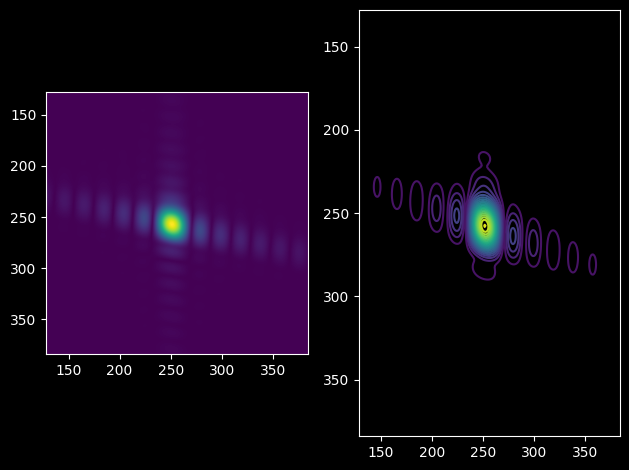

In [12]:
K = 16
N = 32
C_2ft = sf.fft2((C_point))
C_rp_fft = np.zeros([N,K*N],dtype=np.complex128)
for i in range(N):
    x_min = np.argmin(np.abs(C_2ft[i,:]))
    C_rp_fft[i,0:x_min] = C_2ft[i,0:x_min]
    C_rp_fft[i,K*N-(N-x_min):K*N] = C_2ft[i,x_min:N]

C_rp_fft_u = np.zeros([K*N,K*N],dtype=np.complex128)
for j in range(K*N):
    y_min = np.argmin(np.abs(C_rp_fft[:,j]))
    C_rp_fft_u[0:y_min,j] = C_rp_fft[0:y_min,j]
    C_rp_fft_u[K*N-(N-y_min):K*N,j] = C_rp_fft[y_min:N,j]
c_ups = sf.ifft2(C_rp_fft_u )
# c_ups = ss.resample(ss.resample(C_point,K*N,axis=-1),K*N,axis=0)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(c_ups))
plt.xlim(int(K*N/4),3*int(K*N/4))
plt.ylim(3*int(K*N/4),int(K*N/4))


plt.subplot(1,2,2)
plt.contour((np.linspace(0,K*N,K*N)),(np.linspace(0,K*N,K*N)),\
             np.abs(c_ups),levels = 20)
plt.xlim(int(K*N/4),3*int(K*N/4))
plt.ylim(3*int(K*N/4),int(K*N/4))
# plt.contour((np.linspace(0,K*N,K*N))[int(K*N/2-N):int(K*N/2+N)],(np.linspace(0,K*N,K*N))[int(K*N/2-N):int(K*N/2+N)],\
#             np.abs(x_pad[int(K*N/2-N):int(K*N/2+N),int(K*N/2-N):int(K*N/2+N)]))
# plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()




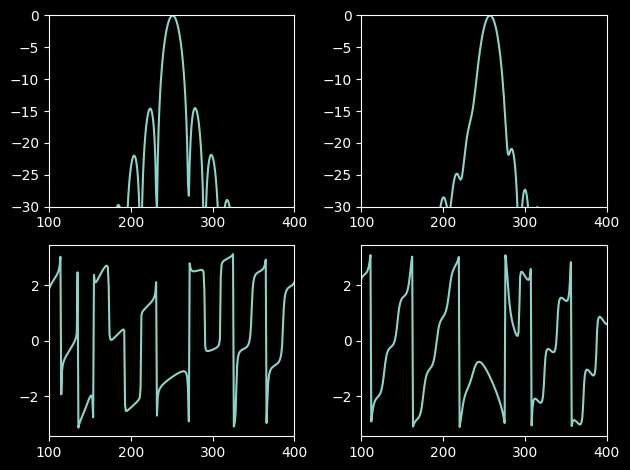

In [13]:
ups_center_y,ups_center_x = np.abs(c_ups).argmax()//c_ups.shape[1],\
                            np.remainder(np.abs(c_ups).argmax(),c_ups.shape[1])

plt.figure()
plt.subplot(2,2,1)
plt.plot(range(c_ups.shape[1]),20*np.log10(np.abs(c_ups[ups_center_y,:])/np.max(np.abs(c_ups[ups_center_y,:]))))
plt.xlim(100,400)
plt.ylim(-30,0)

plt.subplot(2,2,2)
plt.plot(range(c_ups.shape[0]),20*np.log10(np.abs(c_ups[:,ups_center_x])/np.max(np.abs(c_ups[:,ups_center_x]))))
plt.xlim(100,400)
plt.ylim(-30,0)

plt.subplot(2,2,3)
plt.plot(range(c_ups.shape[1]),(np.angle(c_ups[ups_center_y,:])))
plt.xlim(100,400)

plt.subplot(2,2,4)
plt.plot(range(c_ups.shape[0]),(np.angle(c_ups[:,ups_center_x])))
plt.xlim(100,400)

plt.tight_layout()
plt.show()

#旁瓣值较高